# Analyse BlueSeis BSPF Event Analysis - Backazimuth

In [1]:
import os 
import obspy as obs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from andbro__store_as_pickle import __store_as_pickle
from andbro__savefig import __savefig

In [2]:
from functions.compute_backazimuth import __compute_backazimuth

In [3]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

## Configurations

In [4]:
config = {}

## BSPF coordinates
config['BSPF_lon'] = -116.455439
config['BSPF_lat'] = 33.610643

## 
config['path_to_mseed'] = data_path+"BSPF/data/waveforms/"

## event selction
config['path_to_data'] = data_path+"BSPF/data/"

## output path for figures
config['output_figs'] = data_path+"BSPF/figures/baz/"


## Load Data

In [5]:
!ls /home/andbro/kilauea-data/BSPF/data/

adr			    event_selection_reject.pkl
BSPF_2022_E		    hazfaults2014
BSPF_2022_N		    PFO_2022_E
BSPF_2022_Z		    PFO_2022_N
BSPF_2023_E		    PFO_2022_Z
BSPF_2023_N		    PFO_2023_Z
BSPF_2023_Z		    PFOIX_2023_E
bspf_analysisdata_amax.pkl  PFOIX_2023_N
bspf_analysisdata_snr.pkl   PFOIX_2023_Z
BSPF_events_analysis.pkl    trigger3
catalogs		    triggered_2022-10-01_2023-06-15.pkl
event_selection_good.pkl    waveforms


In [6]:
events = obs.read_events(config['path_to_data']+"catalogs/BSPF_catalog_20221001_20230615_all.xml")

event_times = pd.read_pickle(config['path_to_data']+"event_selection_good.pkl")

In [7]:
num = 10

event_time = event_times.origin_time.loc[num]
event = events.filter(f"time >= {event_time}",f"time <= {event_time}")

## prepare string
event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")

In [109]:
st = obs.read(config['path_to_mseed']+f"*{event_time_str}*")

st.detrend("linear")

st.filter("bandpass", freqmin=3.0, freqmax=12, corners=4, zerophase=True)

12 Trace(s) in Stream:
II.PFO.10.BHE  | 2023-03-01T22:48:03.569538Z - 2023-03-01T22:51:03.569538Z | 40.0 Hz, 7201 samples
II.PFO.10.BHN  | 2023-03-01T22:48:03.569538Z - 2023-03-01T22:51:03.569538Z | 40.0 Hz, 7201 samples
II.PFO.10.BHZ  | 2023-03-01T22:48:03.569538Z - 2023-03-01T22:51:03.569538Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJE | 2023-03-01T22:48:03.569538Z - 2023-03-01T22:51:03.569538Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJN | 2023-03-01T22:48:03.569538Z - 2023-03-01T22:51:03.569538Z | 40.0 Hz, 7201 samples
II.RPFO.al.BJZ | 2023-03-01T22:48:03.569538Z - 2023-03-01T22:51:03.569538Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJE | 2023-03-01T22:48:03.569538Z - 2023-03-01T22:51:03.569538Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJN | 2023-03-01T22:48:03.569538Z - 2023-03-01T22:51:03.569538Z | 40.0 Hz, 7201 samples
II.RPFO.in.BJZ | 2023-03-01T22:48:03.569538Z - 2023-03-01T22:51:03.569538Z | 40.0 Hz, 7201 samples
PY.BSPF..HJE   | 2023-03-01T22:48:03.557400Z - 2023-03-01T22:51:03.557400Z | 40.0 Hz, 

In [111]:
cut_offs = [
    (65,80), (65,80), (60,100), (60,100), (60,70),
    (60,90), (60,90), (60,90), (62,105), (65,90),
    (62,110), (65,85), (60,105), (63,105), (66,90),
    (60,90), (65,90), (70,95),
]

# st.trim(st[0].stats.starttime+cut_offs[num][0]-10, st[0].stats.endtime-cut_offs[num][1]+10);
st.trim(st[0].stats.starttime+cut_offs[num][0], st[0].stats.endtime-cut_offs[num][1]);

In [112]:
# st.plot(equal_scale=False);

## BAZ Estimation

In [113]:
config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']

config['eventtime'] = event_time

config['tbeg'], config['tend'] = st[0].stats.starttime, st[0].stats.endtime

## specify window length for baz estimation in seconds
config['win_length_sec'] = 1

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 50

## specify steps for degrees of baz
config['step'] = 1



In [114]:
st.resample(40).trim(st[0].stats.starttime, st[0].stats.endtime)

12 Trace(s) in Stream:
II.PFO.10.BHE  | 2023-03-01T22:49:05.569538Z - 2023-03-01T22:49:13.569538Z | 40.0 Hz, 321 samples
II.PFO.10.BHN  | 2023-03-01T22:49:05.569538Z - 2023-03-01T22:49:13.569538Z | 40.0 Hz, 321 samples
II.PFO.10.BHZ  | 2023-03-01T22:49:05.569538Z - 2023-03-01T22:49:13.569538Z | 40.0 Hz, 321 samples
II.RPFO.al.BJE | 2023-03-01T22:49:05.569538Z - 2023-03-01T22:49:13.569538Z | 40.0 Hz, 321 samples
II.RPFO.al.BJN | 2023-03-01T22:49:05.569538Z - 2023-03-01T22:49:13.569538Z | 40.0 Hz, 321 samples
II.RPFO.al.BJZ | 2023-03-01T22:49:05.569538Z - 2023-03-01T22:49:13.569538Z | 40.0 Hz, 321 samples
II.RPFO.in.BJE | 2023-03-01T22:49:05.569538Z - 2023-03-01T22:49:13.569538Z | 40.0 Hz, 321 samples
II.RPFO.in.BJN | 2023-03-01T22:49:05.569538Z - 2023-03-01T22:49:13.569538Z | 40.0 Hz, 321 samples
II.RPFO.in.BJZ | 2023-03-01T22:49:05.569538Z - 2023-03-01T22:49:13.569538Z | 40.0 Hz, 321 samples
PY.BSPF..HJE   | 2023-03-01T22:49:05.557400Z - 2023-03-01T22:49:13.557400Z | 40.0 Hz, 321 sampl

 -> event used for theoretical backazimuth:
 ->  earthquake name :  20km ESE of Anza, CA

 -> Epicentral distance [m]:       14003.2
 -> Theoretical azimuth [deg]:     8.7
 -> Theoretical backazimuth [deg]: 188.7

 -> using love waves for estimation ...


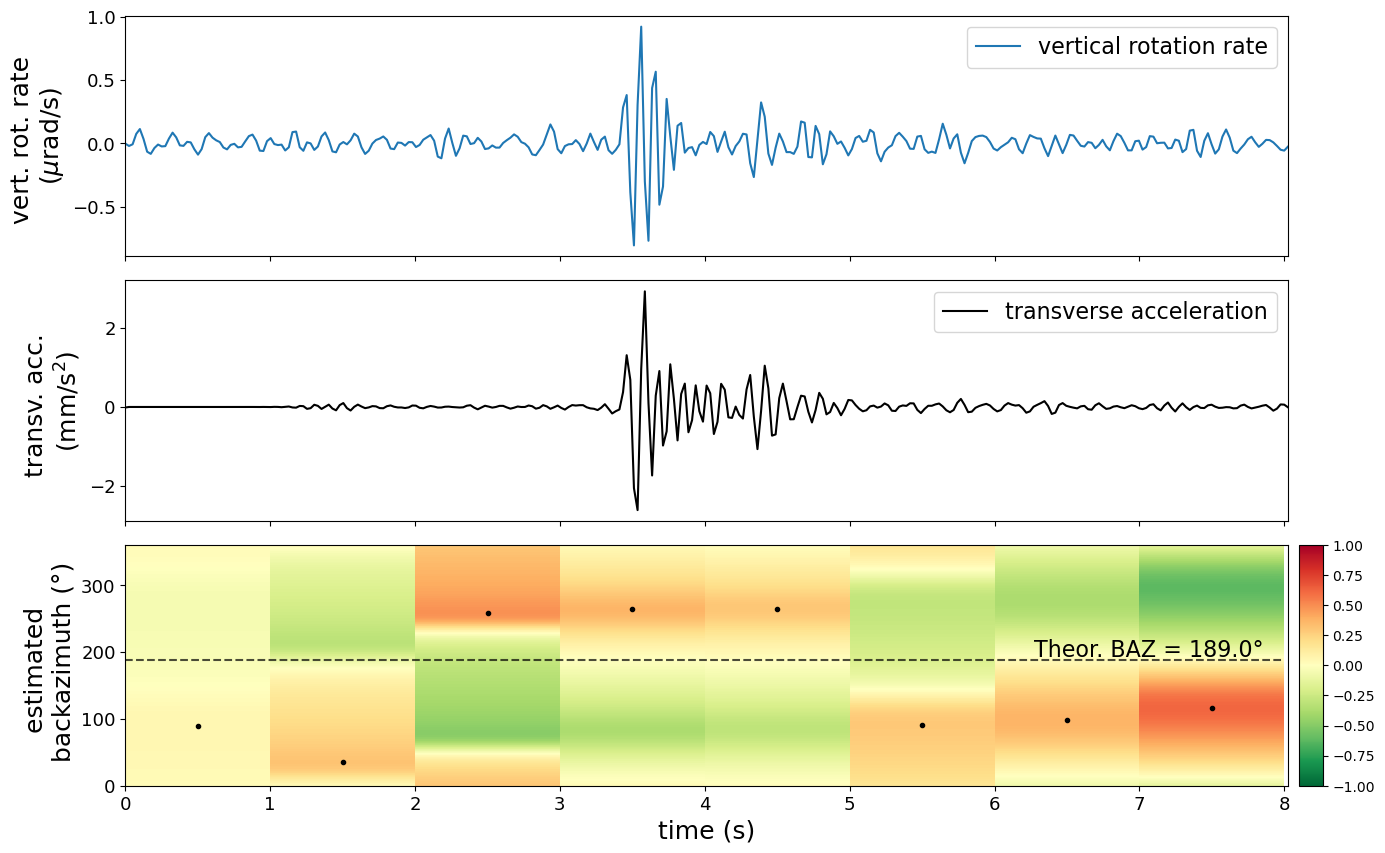

In [115]:
rot = st.select(station="BSPF")
# rot = st.select(station="RPFO", location="in")
acc = st.select(station="PFO*")

config['type'] = "love" ## "love" | "rayleigh"

out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=event[0], plot=True, show_details=True)

In [ ]:
# __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_{config['type']}", mode="png", dpi=200)/

In [ ]:
config['type'] = "rayleigh"
out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=event[0], plot=True, show_details=True)

In [ ]:
# __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_{config['type']}", mode="png", dpi=200)/

## New Approach

In [116]:
rot = st.select(station="BSPF")
acc = st.select(station="PFO*")

In [125]:
def __baz_tangent(rot0, acc0, win_time_s=2.0, overlap=0.5, plot=False):
    
    from numpy import zeros, nan, ones, nanmean, array, nanmax
    from numpy import arctan, pi, linspace, cov, argsort, corrcoef, correlate
    from obspy.signal.rotate import rotate_ne_rt
    from numpy.linalg import eigh
    from obspy.signal.cross_correlation import correlate
    
    npts = rot0[0].stats.npts
    
    df = rot0[0].stats.sampling_rate
    
    ## windows
    t_win = win_time_s
    n_win = int(win_time_s*df)
    nover = int(overlap*n_win)
    
    ## extract components
    rot_n = rot.select(channel="*N")[0].data
    rot_e = rot.select(channel="*E")[0].data
    acc_z = rot.select(channel="*Z")[0].data
            
    ## define windows
    n, windows = 0, []
    while n < npts-n_win:
        windows.append((n,n+n_win))        
        n+=n_win
        

    ## add overlap
    if overlap != 0:
        windows_overlap = []
        for i, w in enumerate(windows):
            if i == 0:
                windows_overlap.append((w[0],w[1]+nover))
            elif i >= int(len(windows)-nover):
                windows_overlap.append((w[0]-nover, w[1]))
            else:
                windows_overlap.append((w[0]-nover, w[1]+nover))
    else:
        windows_overlap = windows
    
    ## compute baz and ccorr for each window
    baz, ccor = zeros(len(windows_overlap)), zeros(len(windows_overlap))
    
    for j, (w1, w2) in enumerate(windows_overlap):
                    
        if int(w2-w1) < 10: 
            print(f" -> not enough samples in window (<10)")
    
        dat = (zeros((len(rot_n[w1:w2]), 2))) 
        dat[:,0] = rot_e[w1:w2]
        dat[:,1] = rot_n[w1:w2]
        
        covar = cov(dat, rowvar=False)
        
        Cprime, Q = eigh(covar, UPLO='U')
        
        loc = argsort(abs(Cprime))[::-1]
        
        Q = Q[:,loc]
        
        baz0 = -arctan((Q[1,0]/Q[0,0]))*180/pi 

        if baz0 <= 0:
            baz0 += 180
        
        ## __________________________-
        ## remove 180° ambiguity

        rot_r, rot_t = rotate_ne_rt(rot_n[w1:w2], rot_e[w1:w2], baz0)
                
#         corr_baz = corrcoef(acc_z[w1:w2], rot_t)[0][1]
        corr_baz = correlate(acc_z[w1:w2], rot_t, 0, 'auto')[0]

        
        if (corr_baz > 0):
            baz0 = (180 + baz0)
            
        
        ## add new values to array
        baz[j] = baz0
        ccor[j] = corr_baz
        
            
    ## define time axis
    t1 = array([w1/df for (w1, w2) in windows_overlap])
    t2 = array([w2/df for (w1, w2) in windows_overlap])

    time = array([((w2-w1)/2+w1)/df for (w1, w2) in windows_overlap])
    terr = t2-t1
    
    if plot:
        
        rot0, acc0 = rot_n, acc_z
        
        cmap = plt.get_cmap("viridis", 10)
        
        fig, ax = plt.subplots(1,1,figsize=(15,5))
        
        ax.plot(array(range(len(rot0)))/df, rot0/max(abs(rot0)), alpha=1, color="grey", label="rotation rate (rad/s)")
        ax.plot(array(range(len(acc0)))/df, acc0/max(abs(acc0)), alpha=0.5, color="tab:red", label="acceleration (m/s)")
        
        
        ax.set_ylim(-1,1)
        ax.set_xlim(0, len(rot0)/df)
        ax.set_xlabel("Time (s)",fontsize=14)
        ax.set_ylabel("Norm. Amplitude",fontsize=14)
        ax.grid(zorder=0)
        ax.legend(loc=4, fontsize=13)
        
        ax2 = ax.twinx()
        cax = ax2.scatter(time, baz, c=ccor, s=50, cmap=cmap, edgecolors="k", lw=1, vmin=0, vmax=1, zorder=2)
        ax2.errorbar(time, baz, xerr=terr, yerr=None, zorder=1, color="lightgrey", marker='o', markersize=2, ls="None")
        ax2.set_ylabel("Backazimuth (°)", fontsize=14)
        ax2.set_ylim(0, 360)
        ax2.set_yticks(np.linspace(ax2.get_yticks()[0], ax2.get_yticks()[-1], len(ax.get_yticks())))
        
        cbar = plt.colorbar(cax, pad=0.08)
        cbar.set_label("Cross-Correlation Coefficient", fontsize=14)
        
        cax.set_clip_on(False)
    
        out = {"time":time, "baz":baz, "ccoef":ccor, "fig":fig}    
    else:    
        out = {"time":time, "baz":baz, "ccoef":ccor}
        
    return out

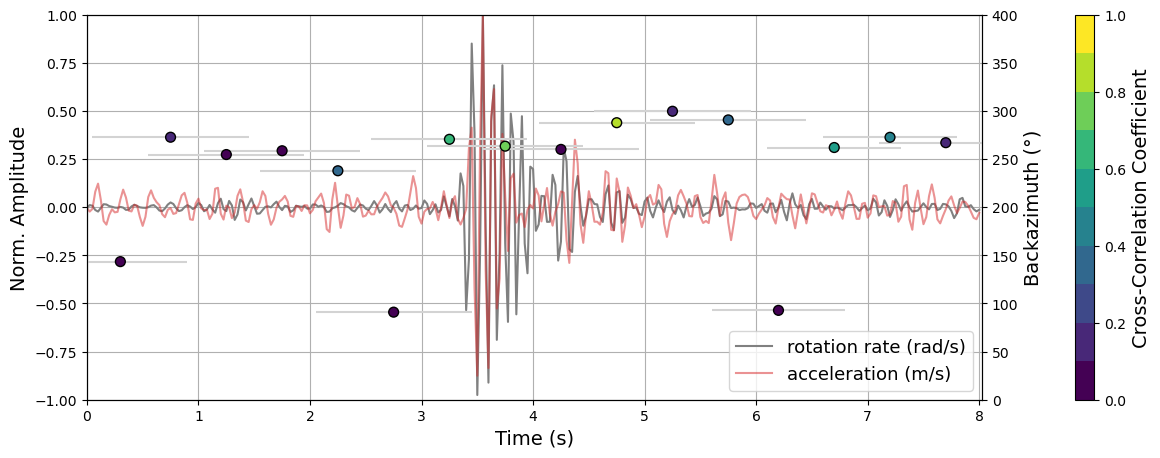

In [126]:
out = __baz_tangent(rot, acc, win_time_s=.5, overlap=0.2, plot=True)

## AS LOOP

In [ ]:

config['station_longitude'] = config['BSPF_lon']
config['station_latitude']  = config['BSPF_lat']
config['eventtime'] = event_time

## specify window length for baz estimation in seconds
config['win_length_sec'] = 2.0

## define an overlap for the windows in percent (50 -> 50%)
config['overlap'] = 20

## specify steps for degrees of baz
config['step'] = 1   

config['type'] = "love"

config['fmin'], config['fmax'] = 5, 12


for i in range(0, 17):
    
    event_time = event_times.origin_time.loc[i]
    
    try:
        event = events.filter(f"time >= {event_time}",f"time <= {event_time}")
    except:
        print(f" -> {i} no event in catalog")

        
        
    ## prepare string
    event_time_str = event_time.split(".")[0].replace(" ","_").replace("-","").replace(":","")
    
    st = obs.read(config['path_to_mseed']+f"*{event_time_str}*")
    st.detrend("simple")
    st.taper(0.01)
    st.filter("bandpass", freqmin=config['fmin'], freqmax=config['fmax'], corners=4, zerophase=True)
    
    st.trim(st[0].stats.starttime+cut_offs[num][0]-10, st[0].stats.endtime-cut_offs[num][1]+10);
    
    rot = st.select(station="BSPF").copy()
    acc = st.select(station="PFO*").copy()
    
    config['tbeg'], config['tend'] = rot[0].stats.starttime, rot[0].stats.endtime
    
    out = __compute_backazimuth(acc, rot, config, wave_type=config['type'], event=event[0], plot=True, show_details=False)
            
    __savefig(out['fig'], config['output_figs'], f"{event_time_str}_baz_{config['type']}", mode="png", dpi=200)
